In [264]:
import theano
import theano.tensor as T
import theano.tensor.nnet as nnet
import numpy as np
import time

import cv2 
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
import time
from math import sqrt
from skimage import transform
import skimage 


In [283]:
import random

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def update(self, x, y):
        
        nabla_b, nabla_w = self.backprop(x, y)        
        self.weights = [w - nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - nb for b, nb in zip(self.biases, nabla_b)]
         
    
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        match_limit = 0.05
        
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(abs(x - y) < match_limit) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))
    


In [253]:

def readTrainingdata(filename):
    
    trainingData = []
    theFile = open(filename, 'r')
    line = theFile.readline()
    while line != None and line != "":
        values = line.split()
        y = np.array([float(values[0])])        
        x = np.asarray(values[1:], dtype=float).reshape(29,1)
        trainingData.append((x, y))
        line = theFile.readline()
    
    return trainingData
        
training_data = createTrainingdata('./trainingSet/train1')
    


# create testdata in right format: 




## 

In [290]:
net = Network([29, 100, 100, 100, 1])

print training_data[0][0].shape

training_data_batch1 = training_data[1000:60000]
training_data_batch2 = training_data[60000:120000]
training_data_batch3 = training_data[120000:180000]

test_data_batch = training_data[0:1000]

net.SGD(training_data_batch1, epochs=2, mini_batch_size=20, eta=.5, test_data=test_data_batch)
net.SGD(training_data_batch2, epochs=2, mini_batch_size=20, eta=.5, test_data=test_data_batch)
net.SGD(training_data_batch3, epochs=2, mini_batch_size=20, eta=.5, test_data=test_data_batch)

(29, 1)
Epoch 0: 77 / 1000
Epoch 1: 77 / 1000
Epoch 0: 77 / 1000
Epoch 1: 77 / 1000
Epoch 0: 77 / 1000
Epoch 1: 77 / 1000


In [259]:
n = len(training_data)
mini_batch_size = 10
mini_batches = [training_data[k:k+mini_batch_size] for k in xrange(0, n, mini_batch_size)]
print len(mini_batches)

26374


In [266]:
circle = lambda r: np.array([[1 if sqrt((i-r)**2 + (j-r)**2) <= r else 0 for j in range(0, 2*r+1)] for i in range(0, 2*r+1)])

def absolute(x, y):
    return(math.sqrt(x**2 + y**2))
vect_absolute = np.vectorize(absolute)

def power(input):
    return input**2
vect_power = np.vectorize(power)

def get_rescaled(img, percent):
    width, height = img.shape
    resized = skimage.transform.resize(img, output_shape=[int(width * percent), 
                int(height * percent)], order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    return resized

def prepImg(fileName, scale):
    img = cv2.imread(fileName, 0)
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    img_rescaled = get_rescaled(dst, scale)    
    return img_rescaled
    
    
img = prepImg('./img/bok11.png', 0.2)    

In [271]:
# repaint image with network 

width, height = img.shape

filtered = np.zeros((width, height))

radius = 3
kernel = circle(radius)
denominator = kernel.sum()
img_force_int = img.astype('float')
for x in range(radius, width-radius):
    for y in range(radius, height-radius):
        crop = img_force_int[x - radius:x + radius + 1, y - radius:y + radius + 1]
        croped_crop = crop[kernel == 1].reshape(29,1)
        output = net.feedforward(croped_crop)
        filtered[x, y] = output
        



In [277]:


print np.amax(filtered)
print np.amin(filtered)

def histEq(image, number_bins=256):

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf



histeq, trash = histEq(filtered)

0.746321069032
0.0


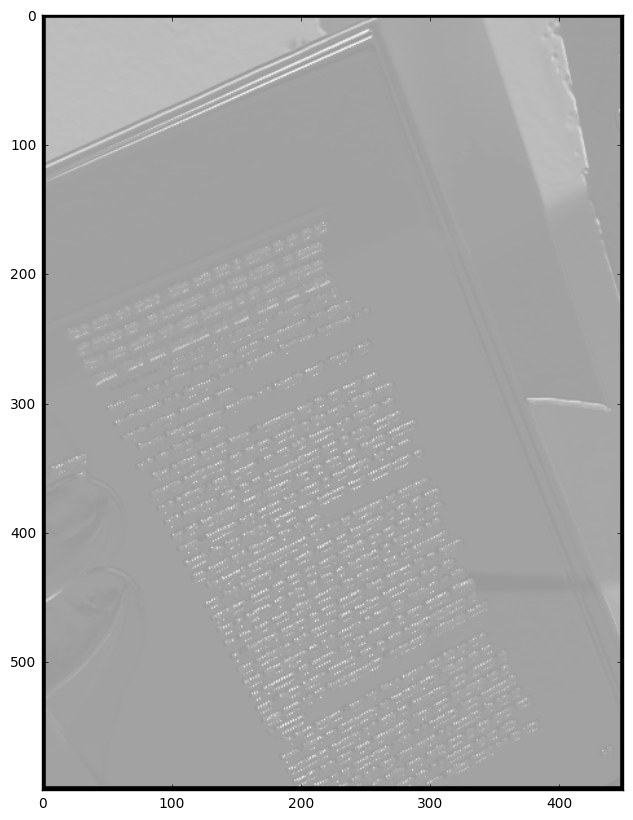

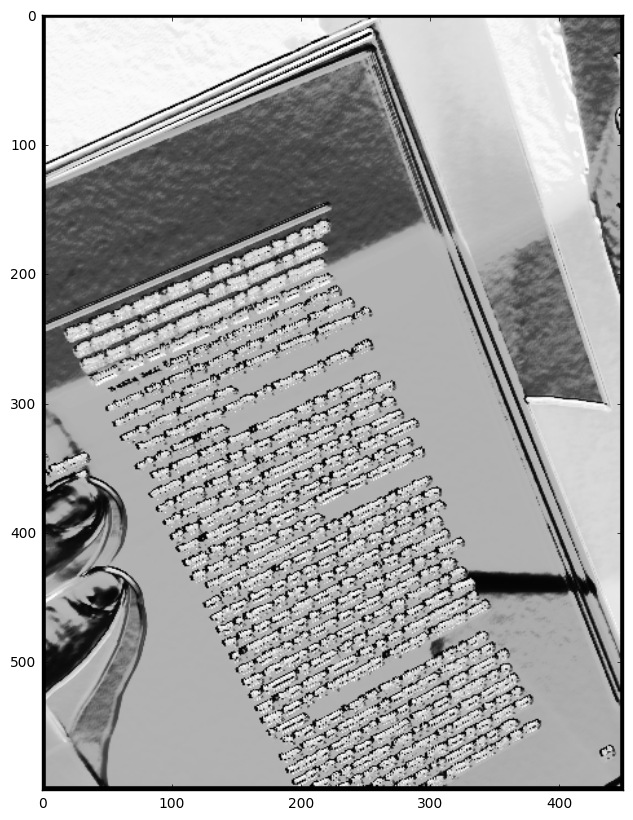

In [278]:
plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(filtered, 'gray')

plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(histeq, 'gray')

In [ ]:
histeq